In [1]:
import os
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets

import autoneuronet as ann

ann.__version__

/Users/rishabalagharu/.pyenv/versions/3.13.7/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'0.1.10'

# MNIST Classification


In [2]:
train_dataset = datasets.MNIST("./data", train=True, download=True)
test_dataset = datasets.MNIST("./data", train=False)

batch_size = 16

In [3]:
train_images = train_dataset.data.numpy()
train_images = train_images.reshape(train_images.shape[0], -1)
train_images = train_images / 255.0

train_labels = train_dataset.targets.numpy()

test_images = test_dataset.data.numpy()
test_images = test_images.reshape(test_images.shape[0], -1)
test_images = test_images / 255.0

test_labels = test_dataset.targets.numpy()

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 784), (60000,), (10000, 784), (10000,))

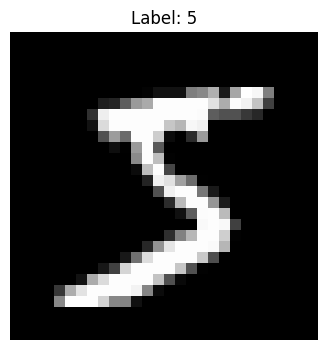

In [4]:
plt.figure(figsize=(4, 4))
plt.imshow(train_images[0].reshape(28, 28), cmap="gray")
plt.title(f"Label: {train_labels[0]}")
plt.axis(False)
plt.show()

In [5]:
def numpy_to_matrix(array: any, *, as_column: bool = False) -> ann.Matrix:
    """Convert a numpy array or sequence to a Matrix."""
    import numpy as np

    numpy_array = np.asarray(array, dtype=float)
    if numpy_array.ndim == 0:
        numpy_array = numpy_array.reshape(1, 1)
    elif numpy_array.ndim == 1:
        numpy_array = (
            numpy_array.reshape((-1, 1)) if as_column else numpy_array.reshape((1, -1))
        )
    elif numpy_array.ndim != 2:
        raise ValueError("Expected a 1D or 2D array")

    rows, cols = numpy_array.shape
    matrix = ann.Matrix(int(rows), int(cols))
    for i in range(rows):
        matrix[i] = numpy_array[i].tolist()

    return matrix

In [6]:
def batch_generator(numpy_array: np.ndarray, batch_size: int = 16):
    num_samples = numpy_array.shape[0]
    for i in range(0, num_samples, batch_size):
        yield numpy_array[i : i + batch_size]

In [7]:
train_images_matrices = []
train_labels_matrices = []

test_images_matrices = []
test_labels_matrices = []

for batch in batch_generator(train_images, batch_size):
    batch_matrix = numpy_to_matrix(batch)
    train_images_matrices.append(batch_matrix)

for batch in batch_generator(train_labels, batch_size):
    batch_matrix = numpy_to_matrix(batch, as_column=True)
    train_labels_matrices.append(batch_matrix)

for batch in batch_generator(test_images, batch_size):
    batch_matrix = numpy_to_matrix(batch)
    test_images_matrices.append(batch_matrix)

for batch in batch_generator(test_labels, batch_size):
    batch_matrix = numpy_to_matrix(batch, as_column=True)
    test_labels_matrices.append(batch_matrix)

In [8]:
lr = 1e-3
beta1 = 0.9
beta2 = 0.999

epochs = 20

model = ann.NeuralNetwork(
    [
        ann.Linear(784, 128, init="kaiming"),
        ann.ReLU(),
        ann.Linear(128, 10, init="kaiming"),
        # ann.Softmax(),
    ]
)
optimizer = ann.AdamOptimizer(learning_rate=lr, model=model, beta1=beta1, beta2=beta2)

model

NeuralNetwork =
Linear(784, 128)
ReLU()
Linear(128, 10)

In [ ]:
# Training Loop
# Epoch: 15 | Train Loss: 0.009353169694727981

for epoch in tqdm(range(epochs), desc="Training the MNIST Neural Network"):
    train_loss = 0.0
    num_train_batches = 0

    training_pbar = tqdm(
        zip(train_images_matrices, train_labels_matrices),
        total=min(
            len(train_images_matrices),
            len(train_labels_matrices),
        ),
        desc=f"Training MNIST Neural Network {epoch + 1}",
    )

    for batched_images_matrix, batched_labels_matrix in training_pbar:
        optimizer.resetGrad()

        # Forward pass
        y_pred = model.forward(batched_images_matrix)

        # Calculate the loss
        loss = ann.CrossEntropyLossWithLogits(batched_labels_matrix, y_pred)
        train_loss += loss.val

        training_pbar.set_postfix(
            loss=f"{loss.val:.8f}",
        )

        # Backpropagation
        loss.setGrad(1.0)
        loss.backward()
        optimizer.optimize()

        num_train_batches += 1

    print(f"Epoch: {epoch + 1} | Train Loss: {train_loss / num_train_batches}")

    os.makedirs("models/mnist", exist_ok=True)
    model.saveWeights(f"models/mnist/mnist_model_epoch_{epoch + 1}.bin")

Training the MNIST Neural Network:   5%|▌         | 1/20 [27:40<8:45:42, 1660.11s/it]

Epoch: 1 | Train Loss: 0.2490118718105092


Training the MNIST Neural Network:  10%|█         | 2/20 [53:06<7:54:27, 1581.52s/it]

Epoch: 2 | Train Loss: 0.11115380134166898


Training the MNIST Neural Network:  15%|█▌        | 3/20 [1:19:14<7:26:20, 1575.31s/it]

Epoch: 3 | Train Loss: 0.07467336945977132


Training the MNIST Neural Network:  20%|██        | 4/20 [1:46:40<7:07:31, 1603.23s/it]

Epoch: 4 | Train Loss: 0.052723398337824454


Training the MNIST Neural Network:  25%|██▌       | 5/20 [2:14:41<6:47:46, 1631.10s/it]

Epoch: 5 | Train Loss: 0.03920023366972124


Training the MNIST Neural Network:  30%|███       | 6/20 [2:43:16<6:27:15, 1659.71s/it]

Epoch: 6 | Train Loss: 0.02928105301610994


Training the MNIST Neural Network:  35%|███▌      | 7/20 [3:12:39<6:06:54, 1693.39s/it]

Epoch: 7 | Train Loss: 0.024465867830439532


Training the MNIST Neural Network:  40%|████      | 8/20 [3:42:26<5:44:41, 1723.47s/it]

Epoch: 8 | Train Loss: 0.019596493088412395


Training the MNIST Neural Network:  45%|████▌     | 9/20 [4:12:09<5:19:20, 1741.90s/it]

Epoch: 9 | Train Loss: 0.016083706147389028


Training the MNIST Neural Network:  50%|█████     | 10/20 [4:42:08<4:53:16, 1759.69s/it]

Epoch: 10 | Train Loss: 0.015404065135808704


Training the MNIST Neural Network:  55%|█████▌    | 11/20 [5:12:00<4:25:25, 1769.53s/it]

Epoch: 11 | Train Loss: 0.012297019269374343


Training the MNIST Neural Network:  60%|██████    | 12/20 [5:41:56<3:56:59, 1777.44s/it]

Epoch: 12 | Train Loss: 0.012845489807468174


Training the MNIST Neural Network:  65%|██████▌   | 13/20 [6:12:03<3:28:24, 1786.32s/it]

Epoch: 13 | Train Loss: 0.01256918631102122


Training the MNIST Neural Network:  70%|███████   | 14/20 [6:42:18<2:59:31, 1795.21s/it]

Epoch: 14 | Train Loss: 0.009990151696830275


Training the MNIST Neural Network:  75%|███████▌  | 15/20 [7:12:41<2:30:17, 1803.47s/it]

Epoch: 15 | Train Loss: 0.009353169694727981


Training the MNIST Neural Network:  75%|███████▌  | 15/20 [7:15:57<2:25:19, 1743.85s/it]


KeyboardInterrupt: 

In [ ]:
# Testing Loop
# Test Loss: 0.10831532428689152
# Test Accuracy: 97.91%

test_loss_sum = 0.0
num_test_batches = 0

test_acc_correct = 0
test_acc_total = 0

testing_pbar = tqdm(
    zip(test_images_matrices, test_labels_matrices),
    total=min(
        len(test_images_matrices),
        len(test_labels_matrices),
    ),
    desc=f"Testing MNIST Neural Network",
)

for batched_images_matrix, batched_labels_matrix in testing_pbar:
    # Forward pass
    y_pred = model.forward(batched_images_matrix)

    # Calculate the loss
    loss = ann.CrossEntropyLossWithLogits(batched_labels_matrix, y_pred)

    test_loss_val = loss.getVal()
    test_loss_sum += test_loss_val

    for i in range(y_pred.rows):
        best_pred = 0
        best_val = y_pred[i, 0].getVal()
        for j in range(1, y_pred.cols):
            val = y_pred[i, j].getVal()

            if val > best_val:
                best_val = val
                best_pred = j

        label = int(batched_labels_matrix[i, 0].getVal())
        if best_pred == label:
            test_acc_correct += 1

        test_acc_total += 1

    testing_pbar.set_postfix(
        loss=f"{test_loss_val:.8f}",
        acc=f"{(test_acc_correct / test_acc_total) * 100:.2f}%",
    )

    num_test_batches += 1

print(f"Test Loss: {test_loss_sum / num_test_batches}")
print(f"Test Accuracy: {(test_acc_correct / test_acc_total) * 100:.2f}%")

Testing MNIST Neural Network: 100%|██████████| 625/625 [04:17<00:00,  2.43it/s, acc=97.91%, loss=0.00000094]

Test Loss: 0.10831532428689152
Test Accuracy: 97.91%


In [9]:
def predict(model: ann.NeuralNetwork, image: np.ndarray, label: int):
    image_matrix = numpy_to_matrix(image.reshape(1, -1))
    logits = model.forward(image_matrix)

    logits_numpy = np.array([logits[0, i].getVal() for i in range(logits.cols)])
    exps = np.exp(logits_numpy - logits_numpy.max())
    probs = exps / exps.sum()

    pred = int(np.argmax(probs))

    plt.figure(figsize=(4, 4))
    plt.imshow(image.reshape(28, 28), cmap="gray")
    title = f"True Label: {label} | Pred Label: {pred}"
    plt.title(title)
    plt.axis(False)
    plt.show()

    return pred, probs

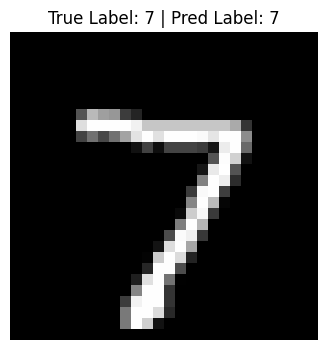

Probs:
0: 0.0000%
1: 0.0000%
2: 0.0000%
3: 0.0000%
4: 0.0000%
5: 0.0000%
6: 0.0000%
7: 100.0000%
8: 0.0000%
9: 0.0000%


In [17]:
idx = 0
pred, probs = predict(model, test_images[idx], test_labels[idx])

print("Probs:")
for i, prob in enumerate(probs):
    print(f"{i}: {prob * 100:.4f}%")

In [10]:
model.loadWeights("models/mnist/mnist_model_epoch_15.bin")